In [1]:
#%pip install pip install sb3-contrib

In [1]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
import random
from gym import Env
from gym.spaces import Discrete, Box
import matplotlib.pyplot as plt
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import BaseCallback
from sb3_contrib import RecurrentPPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy

In [2]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
        
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

In [3]:
def getTickerData(ticker, period, interval):
    hist = yf.download(tickers = ticker, period=period, interval=interval)
    df = pd.DataFrame(hist)
    df = df.reset_index()
    return df

In [4]:
df = getTickerData('btc-usd', 'max', '1d')
df = df.drop(columns={'Volume', 'Adj Close', 'Open', 'High', 'Low'})
df = df.rename(columns={'Close': 'close', 'Date': 'date'})
df['date'] = pd.to_datetime(df['date'])
df

[*********************100%***********************]  1 of 1 completed


,date,close
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014
...,...,...
3141,2023-04-24,27525.339844
3142,2023-04-25,28307.597656
3143,2023-04-26,28422.701172
3144,2023-04-27,29473.787109


In [5]:
rn = random.randint(0, df.value_counts().sum())
i=0
df.shape[0] - rn

1318

8620.56640625


,date,close
1828,2019-09-19,10266.415039
1829,2019-09-20,10181.641602
1830,2019-09-21,10019.716797
1831,2019-09-22,10070.392578
1832,2019-09-23,9729.324219


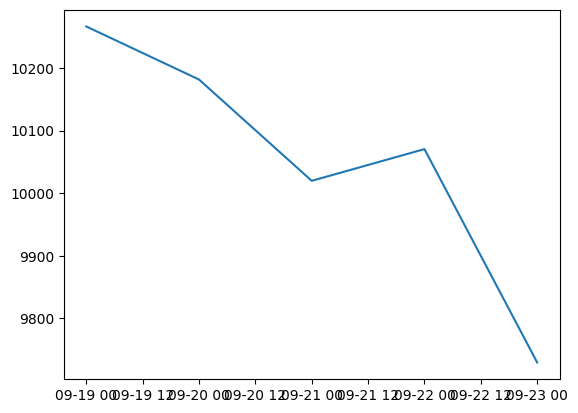

In [6]:
df2 = df.iloc[rn+i:rn+5+i,:]
final_value = df.iloc[rn+5+i]['close']
close_value = df.iloc[rn+4+i]['close']
plt.plot(df2['date'], df2['close'])
print(final_value)
i+=1
df2

In [10]:
class TradingEnv(Env):
    def __init__(self, df, n_steps, window_size) -> None:
        super().__init__()
        self.df = df.drop(columns={'date'})
        self.window_size = window_size
        self.observation_space = Box(low=-np.inf, high=np.inf, shape=(window_size, self.df.shape[1]), dtype=np.float64)
        self.action_space = Discrete(2)
        self.done = None
        
        self.current_step = 0
        self.n_steps = n_steps
        self.random_index = random.randint(0, df.value_counts().sum())
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step+1]['close']
        
        self.long_pos = []
        self.short_pos = []
        
    def step(self, action):
        if action == 0:
            self.short_pos.append(1)
            self.long_pos.append(0)
            reward = self.calculate_reward(action)
        else:
            self.short_pos.append(0)
            self.long_pos.append(1)
            reward = self.calculate_reward(action)
        
        self.final_value = df.iloc[self.random_index+self.window_size+self.current_step]['close']
        self.next_value = df.iloc[self.random_index+self.window_size+self.current_step+1]['close']
        self.current_step += 1
        
        if self.current_step > self.n_steps:
            done = True
        else:
            done = False
        
        observation = self.get_observation()
        info = {}
        
        return observation, reward, done, info
        
    def reset(self):
        self.random_index = random.randint(0, df.value_counts().sum())
        self.done = False
        self.current_step = 0
        return self.get_observation(is_random=True)
    
    def get_observation(self, is_random=False):
        needed_space = self.window_size + self.n_steps*2
        if is_random:
            self.random_index = random.randint(0, df.value_counts().sum())
            if df.shape[0] - self.random_index < needed_space:
                self.random_index = df.shape[0] - needed_space - 1
        return self.df.iloc[self.random_index+self.current_step:self.random_index+self.window_size+self.current_step, :].values
    
    def render_final():
        pass
    
    def calculate_reward(self, action):
        raise NotImplementedError    

In [11]:
env = TradingEnv(df, window_size=90, n_steps=20)

In [12]:
check_env(env)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\env_checker.py:213: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


NotImplementedError: 

769.7310180664062
780.0869750976562


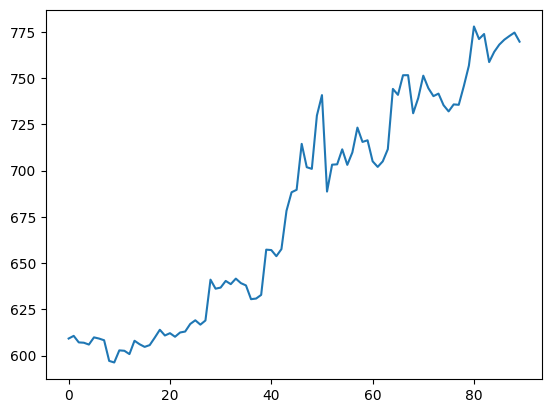

In [43]:
#env.reset()
obs, reward, done, info = env.step(0)
plt.plot(obs)
print(env.final_value)
print(env.next_value)

In [45]:
episodes = 10
for n in range(1, episodes+1):
    obs = env.reset()
    done = False
    score = 0
    while not done:
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'episode - {n} || score - {score}')
    

episode - 1 || score - -1000
episode - 2 || score - -1000
episode - 3 || score - -340
episode - 4 || score - -1110
episode - 5 || score - -670
episode - 6 || score - -450
episode - 7 || score - -1110
episode - 8 || score - -1000
episode - 9 || score - -780
episode - 10 || score - -1000


In [46]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [56]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [57]:
model = RecurrentPPO('MlpLstmPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.0001)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [61]:
model.learn(total_timesteps=140, callback=callback)

Logging to ./logs/RecurrentPPO_4
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 21        |
|    ep_rew_mean     | -1.02e+03 |
| time/              |           |
|    fps             | 214       |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 128       |
----------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 21            |
|    ep_rew_mean          | -1.04e+03     |
| time/                   |               |
|    fps                  | 165           |
|    iterations           | 2             |
|    time_elapsed         | 1             |
|    total_timesteps      | 256           |
| train/                  |               |
|    approx_kl            | 1.6975682e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.693        |
|

In [58]:
loaded_model = RecurrentPPO.load('./train/best_model_151000.zip')

In [60]:
evaluate_policy(loaded_model, env, n_eval_episodes=10)

c:\Users\damem\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-780.0, 245.96747752497686)